In [1]:
import torch
from pathlib import Path
import numpy as np
import json
from progress.bar import IncrementalBar

In [2]:
class Config(dict):
    def __init__(self, *args):
        dict.__init__(self, *args)

    def num_workers(self) -> int:
        import multiprocessing
        return self.get('num_workers', multiprocessing.cpu_count())

    def num_epochs(self) -> int:
        return self.get('num_epochs', 10)

    def batch_size(self) -> int:
        return self.get('batch_size', 64)

    def lr(self) -> float:
        return self.get('lr', 0.001)

    def architecture(self) -> str:
        # Supported: 'nn', 'svm'
        return self.get('architecture', 'nn')

    def target(self) -> str:
        # Get the target column name for the classification task
        return self.get('target', 'class')

    def class_order(self) -> list:
        # Get the order of target classes
        return self.get('class_order', ['<=50K', '>50K'])

    def header_order(self) -> list:
        # Get the order of all variables
        return self.get('header_order', ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class'])

    def categorical_orders(self) -> dict:
        # Get the orders of categorical variables
        return self.get('categorical_orders', {
                'workclass': ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],
                'education': ['Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters', '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool'],
                'marital-status': ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],
                'occupation': ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],
                'relationship': ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'],
                'race': ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],
                'sex': ['Female', 'Male'],
                'native-country': ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']
            })

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data: str, config: Config):
        ''' Initialize the dataset from an xlsx file
        Arguments:
          data: Path to xlsx data file
          config: The configuration for this run
        '''
        self.config = config
        from openpyxl import load_workbook
        wb = load_workbook(data, read_only=True)
        self.raw = list(wb[wb.sheetnames[0]].values)
        self.header = self.raw[1]
        self.raw = self.raw[2:]
        self.data = [self.to_vectors(self.header, line) for line in self.raw]
        wb.close()


    def to_vectors(self, header, line) -> (list, int):
        ''' Convert input to vector representations
        Arguments:
          header: The header of column names
          line: The line of values
        Returs:
          list: The feature vector
          int: The class label
        '''
        # First reformat as dict
        data = {name: val for name, val in zip(header, line)}
        # Accumulate results
        results = []
        label = -1
        # Process in fixed order
        for name in self.config.header_order():
            val = data[name]
            # Some vals have a leading space we need to trim
            if type(val) is str:
                val = val.strip()
            if name == self.config.target():
                # Test set appends '.'
                if val[-1] == '.':
                    val = val[:-1]
                label = self.config.class_order().index(val)
            elif name in self.config.categorical_orders():
                onehot = [0 for _ in range(len(self.config.categorical_orders()[name]))]
                if val != '?': # Apparently can be unknown. TODO: Investigate making small nonzero value in all?
                    onehot[self.config.categorical_orders()[name].index(val)] = 1
                results.extend(onehot)
            else:
                results.append(val)
        return np.array(results), label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        datum, label = self.data[idx]
        return datum, {'label': label, 'id': str(idx)}

In [ ]:
class ModelNN(torch.nn.Module):
    def __init__(self, config):
        super(ModelNN, self).__init__()
        self.config = config
        self.input_len = len(self.config.header_order()) - len(self.config.categorical_orders()) - 1 + sum(len(categorical) for categorical in self.config.categorical_orders().values()) # 105
        # Simple multi-layer perceptron with one-hot output.
        # I prefer one-hot even for binary classification because that's one less thing to change if we go to 3+ classes.
        self.layers = torch.nn.Sequential(torch.nn.Linear(self.input_len, 64), torch.nn.ReLU(),
                                          torch.nn.Linear(64, 16), torch.nn.ReLU(),
                                          torch.nn.Linear(16, len(self.config.class_order())), torch.nn.Sigmoid())

    def forward(self, x):
        return self.layers(x)

In [ ]:
def loadModel(modelPath: str = None, config: Config = None):
    '''Load the model from the disk. Smart enough to load either neural network architecture or svm.
    Arguments:
      modelPath: Location of the model (default: create uninitialized model)
      config: Config object
    Returns:
      The model that was loaded
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    weights = None
    optimizer_state_dict = None
    scaler = None
    if modelPath:
        modelDict = torch.load(modelPath, map_location=device)
        if 'model_state_dict' in modelDict:
            weights = modelDict['model_state_dict']
        if config is None and 'config' in modelDict:
            config = Config(modelDict['config'])
        if 'optimizer_state_dict' in modelDict:
            optimizer_state_dict = modelDict['optimizer_state_dict']
        if 'scaler' in modelDict:
            scaler = modelDict['scaler']
    if config is None:
        config = Config()
    if config.architecture() == 'nn':
        model = ModelNN(config)
        if weights is not None:
            model.load_state_dict(weights)
    elif config.architecture() == 'svm':
        from sklearn.svm import LinearSVC
        model = LinearSVC(dual='auto')
        if weights is not None:
            model = weights
        model.config = config
    model.optimizer_state_dict = optimizer_state_dict
    model.scaler = scaler
    return model

In [6]:
def saveModel(model, savepath):
    if model.config.architecture() == 'svm':
        torch.save({'model_state_dict': model, 'config': dict(model.config), 'scaler': model.scaler}, savepath)
    else:
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': model.optimizer_state_dict, 'config': dict(model.config), 'scaler': model.scaler}, savepath)

In [ ]:
def infer(dataset, model, train: bool = False, barLabel: str = 'Inferring') -> (dict, dict, float):
    ''' Perform inferrence over the dataset
    Arguments:
      dataset: The dataloader to use
      model: The model on which inferrence will be performed
      train: Set to True to train the model using backpropogation
      barLabel: Printed label on the progress bar

    Returns:
      dict: Predicted labels as {id: int}
      dict: Ground truth labels as {id: int} or None if gt not provided
      float: Loss if gt provided
    '''
    if train:
        # Fit the scaler
        from sklearn import preprocessing
        model.scaler = preprocessing.StandardScaler()
        model.scaler.fit([datum for datum, extras in dataset])

    classWeights = [1 - sum(1 for _, extras in dataset if extras['label'] == lab) / len(dataset) for lab in range(len(dataset.config.class_order()))]

    if dataset.config.architecture() == 'svm':
        # sklearn handles the training process
        X = model.scaler.transform([datum for datum, _ in dataset])
        y = [extras['label'] for _, extras in dataset]
        IDs = [extras['id'] for _, extras in dataset]
        if train:
            model.fit(X, y, sample_weight = [classWeights[yVal] for yVal in y])
        pred = model.decision_function(X)
        return {ID: p for ID, p in zip(IDs, pred)}, {ID: l for ID, l in zip(IDs, y)}, 0.0

    # Working with a neural network, we train using back propogation.
    loader = torch.utils.data.DataLoader(dataset, batch_size=dataset.config.batch_size(), shuffle=train, num_workers=dataset.config.num_workers())
    optimizer = None
    if train:
        # Set up the optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=dataset.config.lr())
        if model.optimizer_state_dict is not None:
            optimizer.load_state_dict(model.optimizer_state_dict)
        model.train()
    else:
        model.eval()
    # Ideally loss function would be a configurable parameter, but this is only supposed to be a 4-8 hr project, so...
    loss_func = torch.nn.CrossEntropyLoss(weight=torch.Tensor(classWeights))
    device = next(model.parameters()).device
    # Make a progress bar. Turns out doesn't play nice with Jupyter. Ah well, I debugged it on cli.
    suffix = '%(index)d/%(max)d - %(elapsed)d s - loss: %(loss).4f'
    bar = IncrementalBar(barLabel, width=10, max=len(loader), suffix=suffix)
    bar.loss = 0.0
    predictions = {}
    labels = {}
    for i, (data, extras) in enumerate(loader):
        data = model.scaler.transform(data)
        data = torch.from_numpy(data).float()
        with torch.set_grad_enabled(train):
            if train:
                optimizer.zero_grad()
            outputs = model(data.to(device))
            label = torch.nn.functional.one_hot(extras['label'].long(), num_classes=outputs.shape[1]).float()
            loss = loss_func(outputs, label)
            bar.loss = (bar.loss * i + loss.item()) / (i+1)
            if train:
                loss.backward()
                optimizer.step()
            from copy import deepcopy
            for ID, label, output in list(zip(extras['id'], label, deepcopy(outputs.detach().cpu().numpy()))):
                predictions[ID] = output.tolist()
                labels[ID] = label.tolist()
            del outputs
        bar.next()
    bar.finish()
    if train:
        model.optimizer_state_dict = optimizer.state_dict()
    return predictions, labels, bar.loss

In [8]:
def evaluate(predictions: dict, labels: dict, save: str = None, config: dict = None) -> dict:
    ''' Evaluate results
    Arguments:
      predictions: Predictions formatted {subID: prediction}
      labels: Ground truth formatted {subID: label}
      save: If not none, save results to given directory
      config: Save a copy of the config to save directory

    Returns:
      dict: Dictionary of {metric: value}
    '''
    # Reformat dicts as lists
    keys = list(predictions.keys())
    pred, lab = [[d[key] for key in keys] for d in (predictions, labels)]
    # Currently encoded as 1-hot, but treat as binary (micro-averaging) for ROC
    pred = np.ravel(pred)
    lab = np.ravel(lab)
    # Do all the metric calculations
    from sklearn import metrics
    fpr, tpr, thresh = metrics.roc_curve(lab, pred)
    auc = metrics.auc(fpr, tpr)
    fnr = 1-tpr
    eerIndex = np.nanargmin(np.absolute((fnr - fpr)))
    eer = (fpr[eerIndex] + fnr[eerIndex]) / 2
    recall = 1-fnr[eerIndex]
    pp = sum(1 for p in pred if p >= thresh[eerIndex])
    tp = sum(1 for p, l in zip(pred, lab) if p >= thresh[eerIndex] and l == 1)
    pn = sum(1 for p in pred if p < thresh[eerIndex])
    tn = sum(1 for p, l in zip(pred, lab) if p < thresh[eerIndex] and l == 0)
    precision = 0 if pp == 0 else tp/pp
    npv = 0 if pn == 0 else tn / pn
    f1 = (2*precision*recall)/(precision+recall)
    mcc = np.sqrt(tpr[eerIndex]*(1-fpr[eerIndex])*precision*npv) - np.sqrt(fnr[eerIndex]*fpr[eerIndex]*(1-npv)*(1-precision))
    accuracy = (tp+tn)/(len(pred))
    results = {'AUC': auc, 'EER': eer, 'Precision': precision, 'Recall': recall, 'F_1': f1, 'MCC': mcc, 'Accuracy': accuracy}
    if save is not None:
        from pathlib import Path
        savedir = Path(save)
        savedir.mkdir(parents=True, exist_ok=True)
        for fname, dic in [['results.json', results], ['predictions.json', predictions], ['labels.json', labels], ['config.json', config]]:
            if dic is not None:
                with (savedir / fname).open('w') as f:
                    json.dump(dic, f)
        import matplotlib.pyplot as plt
        plt.figure()
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot([0, 1], [0, 1], linestyle = '--')
        plt.plot(fpr, tpr)
        plt.axis('square')
        plt.tight_layout()
        plt.savefig(savedir/'ROC.png')
        plt.close()
    return results

In [9]:
def print_table(data: dict, delimiter: str = '  ', floatPrecision: int = 3, end: str = ''):
    ''' Print a nicely formatted table
    Arguments:
      data: Dictionary of {header: values}
      delimiter: String placed between columns
      floatPrecision: Values after the decimal point
      end: String to print at the end of a line
    '''
    header = list(data.keys())
    if type(data[header[0]]) is not list: # Unify formatting
        data = {h: [v] for h, v in data.items()}
    # Convert to 2d array
    data = [[h, *data[h]] for h in header]
    def toStr(value):
        if isinstance(value, (np.floating, float)):
            value = f'{value:.{floatPrecision}f}'
        return str(value)
    widths = [max(len(toStr(v)) for v in d) for d in data]
    data = list(zip(*data))
    for row in data:
        print(delimiter.join(f'{toStr(v):<{w}}' for v, w in zip(row, widths)) + end)

In [ ]:
def train(ds, output: str):
    ''' Train a model
    Arguments:
      ds: Dataset object for training
      output: Path to the directory to save traing output
    '''
    outpath = Path(output)
    initEpoch = 0
    saveStem = ds.config.architecture()
    initModel = None
    if outpath.is_dir():
        # We might be resuming training
        models = [p for p in outpath.glob(f'{saveStem}_*') if p.is_file()]
        if len(models) >= 1:
            initEpoch = max(int(p.stem.split('_')[1][1:]) for p in models)
            initModel = outpath / f'{saveStem}_e{initEpoch}'
            initEpoch += 1
    model = loadModel(modelPath=initModel, config=ds.config)

    # Save config
    outpath.mkdir(parents=True, exist_ok=True)
    with (outpath / 'config.json').open('w') as f:
        json.dump(ds.config, f)

    # Randomly partition into training/validation data
    # TODO: Figure out how to save/restore random splits for resuming training.
    # Actually, this probably isn't a necessary feature when training 10 epochs takes 15 seconds.
    train_ds, val_ds = torch.utils.data.random_split(ds, [0.8,0.2]) # Could also fix rng for reproducibility
    # We pass the config around as a dataset member
    train_ds.config = ds.config
    val_ds.config = ds.config
    for epoch in range(initEpoch, ds.config.num_epochs()):
        _, _, loss = infer(train_ds, model, train=True, barLabel='Training')
        pred, labels, loss = infer(val_ds, model)
        print_table(evaluate(pred, labels))
        # Save the model
        savepath = outpath / f'{saveStem}_e{epoch}'
        saveModel(model, savepath)
        print(f'Saved model to {savepath}\n')

In [11]:
def test(ds, model: str, save: str = None):
    ''' Test a model
    Arguments:
      ds: Dataset object for training
      model: Path to the model to test
      save: Path to save evaluation results
    '''
    model = loadModel(modelPath=model, config=ds.config)
    pred, labels, loss = infer(ds, model)
    results = evaluate(pred, labels, save=save)
    print_table(results)
    if save:
        saveModel(model, Path(save)/'model')

In [12]:
# Now we get the interactive portion!
config = Config() # Use defaults, will do NN training
ds_train = Dataset('au_train.xlsx', config)
ds_test = Dataset('au_test.xlsx', config)
models = Path('training/')
import shutil
if models.is_dir():
    shutil.rmtree(models)
train(ds_train, models/config.architecture())

AUC    EER    Precision  Recall  F_1    MCC    Accuracy
0.881  0.205  0.795      0.795   0.795  0.590  0.795   
Saved model to training/nn/nn_e0

AUC    EER    Precision  Recall  F_1    MCC    Accuracy
0.883  0.200  0.800      0.800   0.800  0.600  0.800   
Saved model to training/nn/nn_e1

AUC    EER    Precision  Recall  F_1    MCC    Accuracy
0.892  0.195  0.805      0.805   0.805  0.610  0.805   
Saved model to training/nn/nn_e2

AUC    EER    Precision  Recall  F_1    MCC    Accuracy
0.898  0.190  0.810      0.810   0.810  0.620  0.810   
Saved model to training/nn/nn_e3

AUC    EER    Precision  Recall  F_1    MCC    Accuracy
0.905  0.182  0.818      0.818   0.818  0.637  0.818   
Saved model to training/nn/nn_e4

AUC    EER    Precision  Recall  F_1    MCC    Accuracy
0.897  0.192  0.808      0.808   0.808  0.617  0.808   
Saved model to training/nn/nn_e5

AUC    EER    Precision  Recall  F_1    MCC    Accuracy
0.891  0.201  0.799      0.799   0.799  0.598  0.799   
Saved model 

In [13]:
# Just test on the final model. We could also perform model selection based on validation loss.
test(ds_test, models/config.architecture()/f'{config.architecture()}_e{config.num_epochs()-1}', save=models/config.architecture()/'test')

AUC    EER    Precision  Recall  F_1    MCC    Accuracy
0.906  0.187  0.813      0.813   0.813  0.626  0.813   


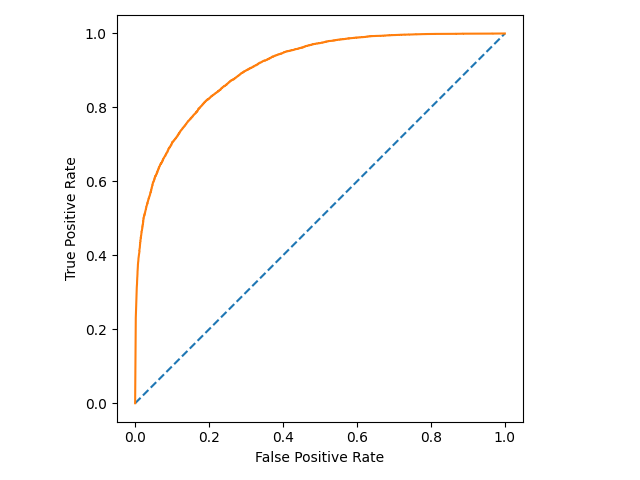

In [14]:
# View the ROC curve
from IPython.display import Image
Image(models/config.architecture()/'test'/'ROC.png')

In [15]:
# Now let's do a svm
config['architecture'] = 'svm'
config['num_epochs'] = 1
train(ds_train, models/config.architecture())

AUC    EER    Precision  Recall  F_1    MCC    Accuracy
0.906  0.182  0.579      0.818   0.678  0.572  0.818   
Saved model to training/svm/svm_e0



In [16]:
test(ds_test, models/config.architecture()/f'{config.architecture()}_e{config.num_epochs()-1}', save=models/config.architecture()/'test')

AUC    EER    Precision  Recall  F_1    MCC    Accuracy
0.904  0.181  0.583      0.819   0.681  0.575  0.819   


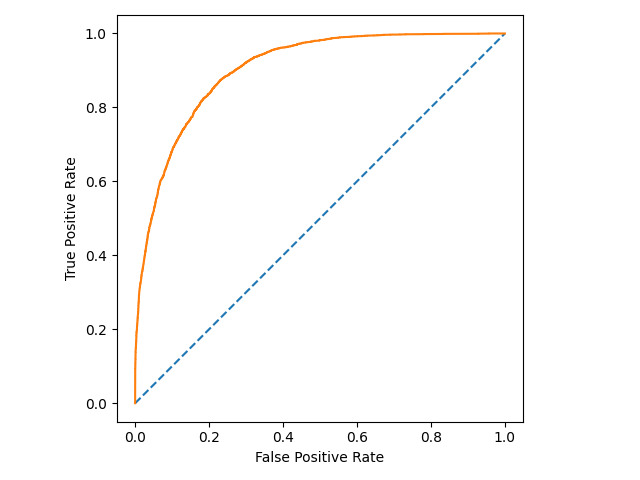

In [17]:
Image(models/config.architecture()/'test'/'ROC.png')

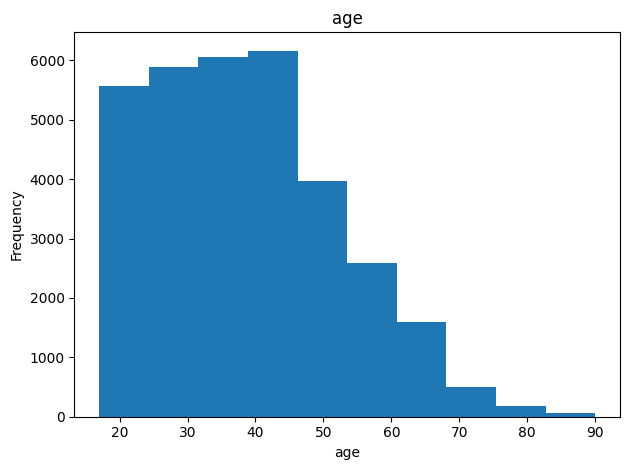

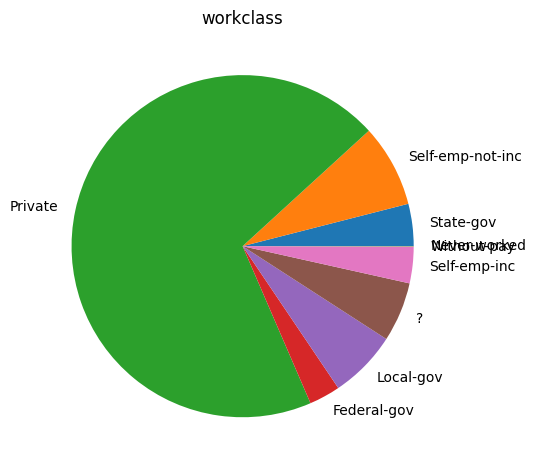

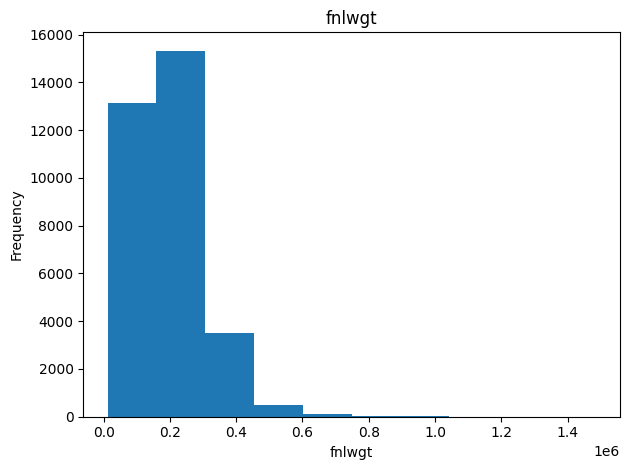

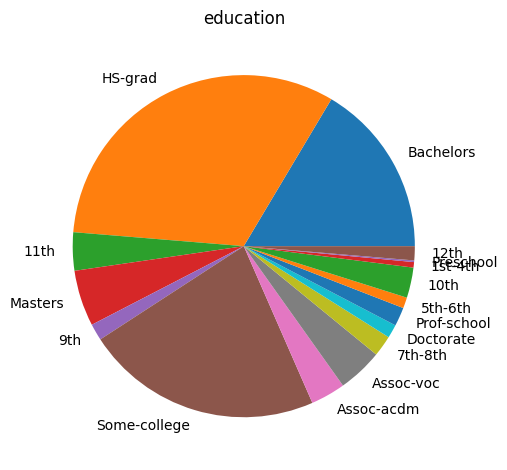

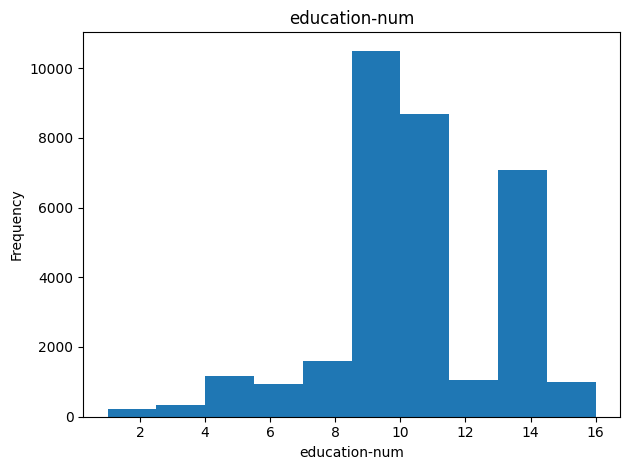

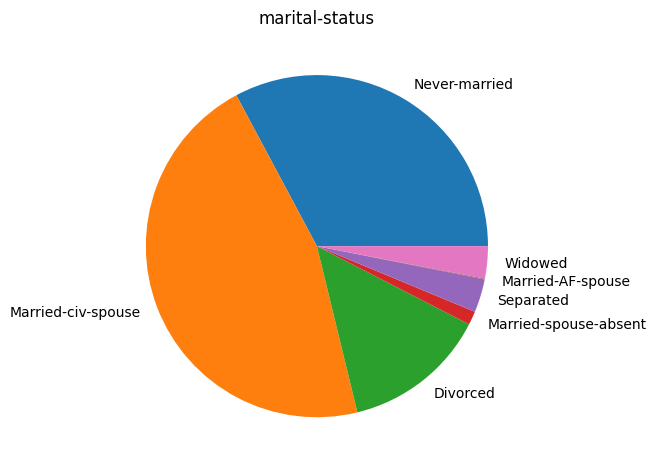

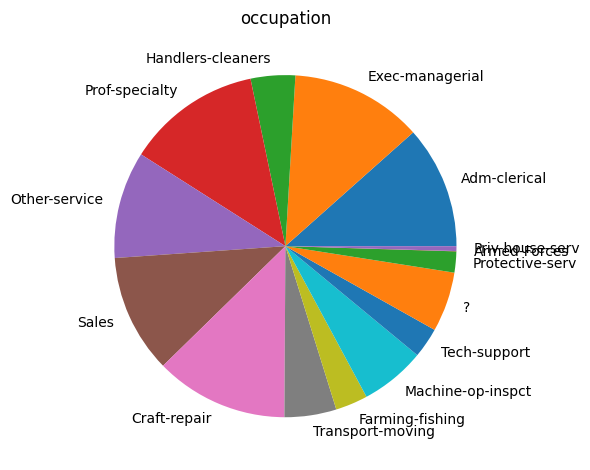

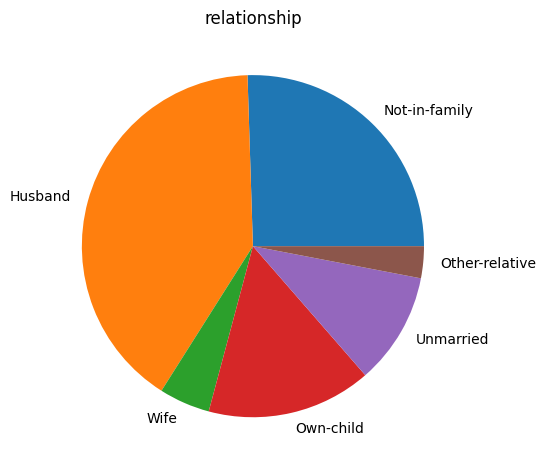

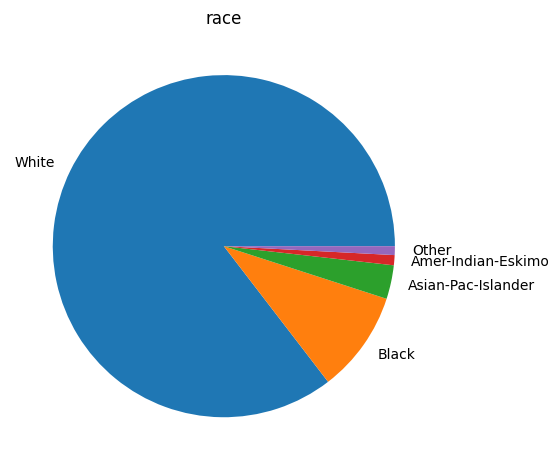

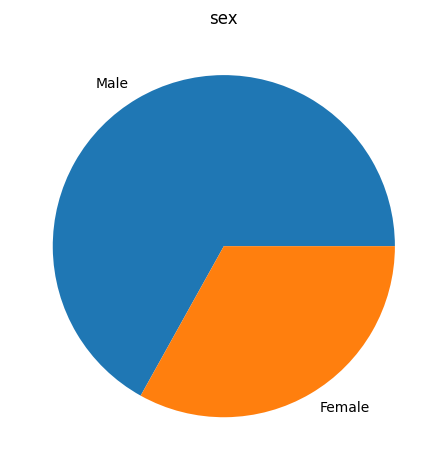

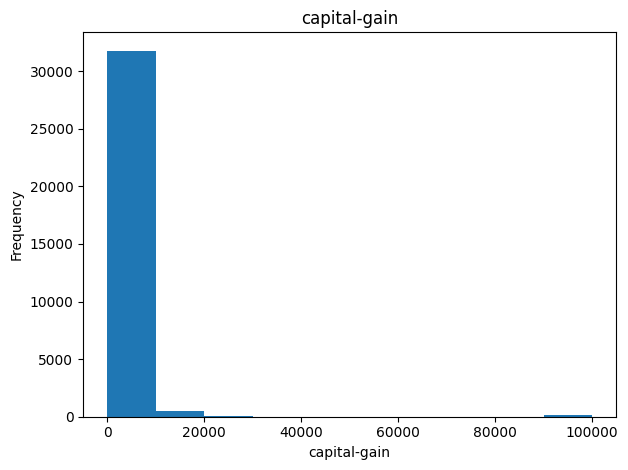

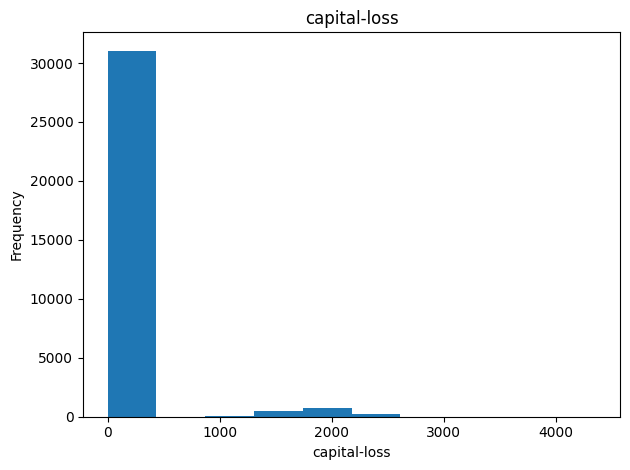

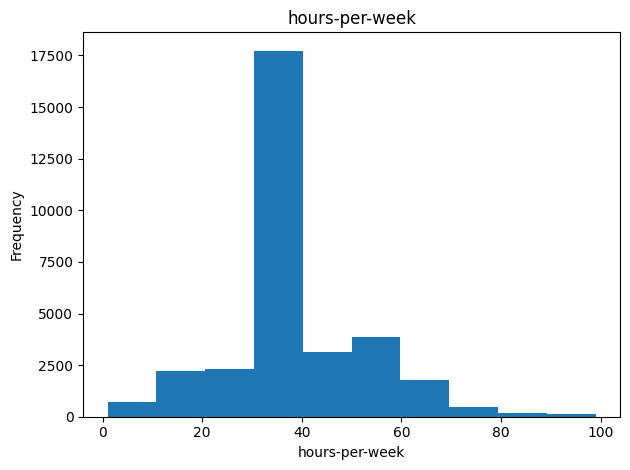

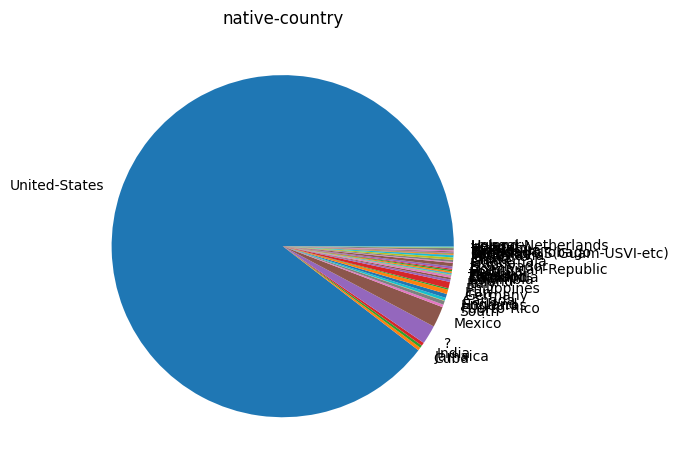

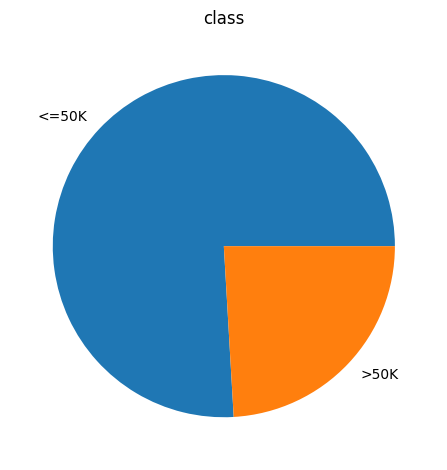

In [18]:
# Segmentation study: This is purely exploratory for me, as I don't have much prior intuition
# regarding the relationships between the variables and classes, nor what the most relavent
# questions would be.

savedir = models/'visualizations'
savedir.mkdir(exist_ok=True)

# Plot all variables
for column in config.header_order():
    import matplotlib.pyplot as plt
    plt.figure()
    plt.title(column)
    index = ds_train.header.index(column)
    vals = [line[index] for line in ds_train.raw]
    if column in config.categorical_orders() or column == config.target():
        counts = {}
        for val in vals:
            val = val.strip()
            if val not in counts:
                counts[val] = 0
            counts[val] += 1
        labels = list(counts.keys())
        plt.pie([counts[key] for key in labels], labels=labels)
    else: # It's continuous
        plt.hist(vals)
        plt.xlabel(column)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(savedir/f'{column}.png')
    Image(savedir/f'{column}.png')

In [19]:
# Start by visualizing the 2d projection. I've used MDS before so here it goes,
# but if I was spending more than 8 hours on this I'd want to be more selective.

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform([datum for datum, _ in ds_train])
from sklearn.manifold import MDS
embedding = MDS(normalized_stress='auto', n_init=1)
X = embedding.fit_transform(X) # Consumes ~50G memory per job

/home/nathan/bin/p3/.p3env/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


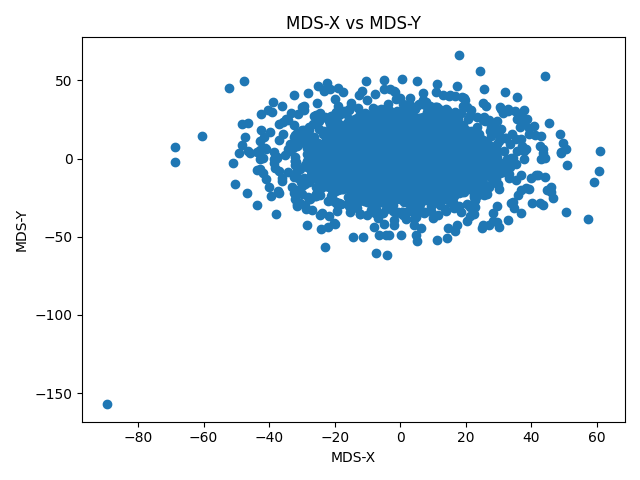

In [20]:
def scatter(x, y, xname, yname):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.title(f'{xname} vs {yname}')
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.scatter(x, y)
    plt.tight_layout()
    plt.savefig(savedir/f'{xname}-{yname}.png')
    plt.close()
    return savedir/f'{xname}-{yname}.png'
Image(scatter(X[:,0], X[:,1], 'MDS-X', 'MDS-Y'))
# Kind of cloud-ish. As I said, more 2d projections exist, and with more time I'd want to try a few more.

In [35]:
from kmodes.kprototypes import KPrototypes
clust = KPrototypes()
data = []
for line in ds_train.raw:
    data.append([])
    for name, val in zip(ds_train.header, line):
        # Some vals have a leading space we need to trim
        if type(val) is str:
            val = val.strip()
        if name == config.target():
            data[-1].append(config.class_order().index(val))
        elif name in config.categorical_orders():
            if val == '?':
                data[-1].append(-1)
            else:
                data[-1].append(config.categorical_orders()[name].index(val))
        else:
            data[-1].append(val)
data = np.array(data)
labels = clust.fit_predict(data, categorical=[i for i, cat in enumerate(ds_train.header) if cat in config.categorical_orders()])


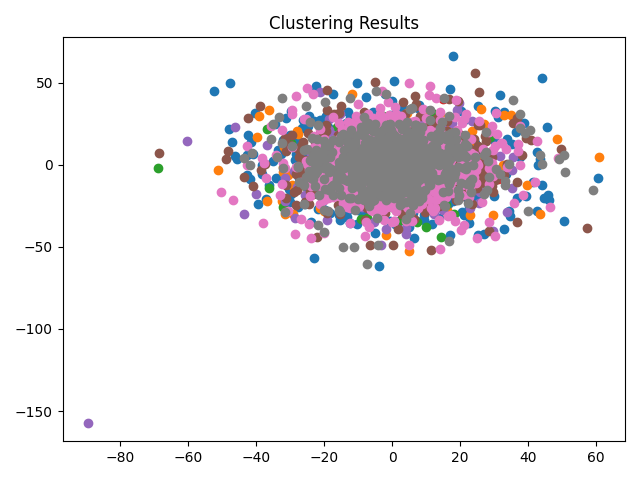

In [40]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('Clustering Results')
for label in set(labels):
    x_label = np.array([x for lab, x in zip (labels, X) if lab == label])
    plt.scatter(x_label[:,0], x_label[:,1], label=label)
plt.tight_layout()
plt.savefig(savedir/'kprototypes.png')
plt.close()
Image(savedir/'kprototypes.png')
# Reinforces that MDS wasn't the best choice. But it's been 8 hours, so I think I'll leave it at that.